## Importing terrain layers from SRTM or 3DEP datasets using ssrs.Terrain module
### Region in Wyoming

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
from ssrs import Terrain, TurbinesUSWTB
from ssrs.raster import transform_bounds, transform_coordinates, get_raster_in_projected_crs
from ssrs.utils import get_extent_from_bounds, create_gis_axis

In [4]:
# directory where output is saved
output_dir = os.path.join(os.path.abspath(os.path.curdir), 'output/')

In [5]:
# Parameters for determining the region of interest
proj_crs = 'ESRI:102008' # projected crs
lonlat_crs = 'EPSG:4326' # geo crs
southwest_lonlat = (-106.14, 42.77) # southwestern point
region_width_km = (60., 50.) # region size in km
resolution = 100. # resolution in meters

In [6]:
# figure out the grid size of the target region
xsize = int(round((region_width_km[0] * 1000. / resolution)))
ysize = int(round((region_width_km[1] * 1000. / resolution)))
gridsize = (ysize, xsize)

In [7]:
# get the bounds of the revion in both lonlat and projected crs
proj_west, proj_south = transform_coordinates(lonlat_crs, proj_crs, southwest_lonlat[0], southwest_lonlat[1])
proj_east = proj_west[0] + xsize * resolution
proj_north = proj_south[0] + ysize * resolution
bounds = (proj_west[0], proj_south[0], proj_east, proj_north)
extent = get_extent_from_bounds(bounds)
lonlat_bounds = transform_bounds(bounds, proj_crs, lonlat_crs)

In [8]:
#Valid terrain layers
Terrain.valid_layers

('DEM',
 'Hillshade Gray',
 'Aspect Degrees',
 'Aspect Map',
 'GreyHillshade_elevationFill',
 'Hillshade Multidirectional',
 'Slope Map',
 'Slope Degrees',
 'Hillshade Elevation Tinted',
 'Height Ellipsoidal',
 'Contour 25',
 'Contour Smoothed 25',
 'SRTM1',
 'SRTM3')

In [9]:
# downloading terrain layers
terrain_layers = {
    'Elevation': 'DEM',
    'Slope': 'Slope Degrees',
    'Aspect': 'Aspect Degrees'
}
region = Terrain(lonlat_bounds, output_dir)
region.download(terrain_layers.values())

Terrain: Bounds set to [-106.21, 42.77, -105.36, 43.24]
Terrain: Found saved raster data for DEM
Terrain: Found saved raster data for Slope Degrees
Terrain: Found saved raster data for Aspect Degrees


In [10]:
def get_terrain_layer(lyr:str):
    fpath = region.get_raster_fpath(lyr)
    return get_raster_in_projected_crs(fpath, bounds, gridsize, resolution, proj_crs)

In [11]:
# get all the wind turbines in this region
turbines = TurbinesUSWTB(bounds, proj_crs, min_hubheight=60.)
turb_xlocs, turb_ylocs = turbines.get_locations()
turbines.print_details()

TurbinesUSWTB: Importing turbine data from USWTB..
TurbinesUSWTB: Minimum hub height set to 60.0 m
Number of projects: 8
Number of turbines: 462
Hub height (min,median,max): 80.0, 80.0, 89.0
Rotor Dia (min,median,max): 77.0, 91.0, 127.0
    Project                   State Year  Count Hub_Hght  Rotor_Dia 
1.  Cedar Springs III         WY    2020  46    89.0      127.0     
2.  Cedar Springs I           WY    2020  60    89.0      127.0     
3.  Cedar Springs II          WY    2020  22    89.0      127.0     
4.  Top of the World          WY    2010  110   80.0      77.0      
5.  Glenrock III              WY    2009  26    80.0      91.0      
6.  Rolling Hills             WY    2009  66    80.0      91.0      
7.  Glenrock                  WY    2008  66    80.0      91.0      
8.  Campbell Hill             WY    2009  66    80.0      77.0      


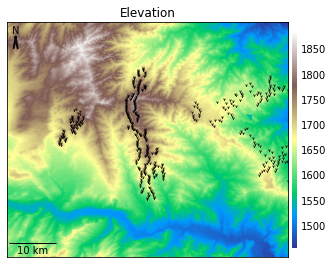

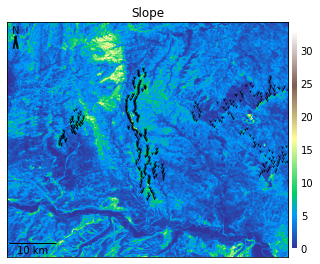

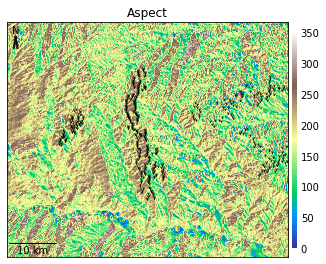

In [12]:
# plot all the layers
for key, val in terrain_layers.items():
    lyr_data = get_terrain_layer(val)
    fig, ax = plt.subplots(figsize=(6,5))
    cm = ax.imshow(lyr_data, cmap='terrain', extent=extent, origin='lower')
    create_gis_axis(fig, ax, cm)
    ax.plot(turb_xlocs, turb_ylocs, '1k', alpha=0.75, markersize=3.)
    ax.set_title(key)